IN PROGRESS<p>
using tensorflow to classify images via Tensorflow.org tutorial
using techniques from class in combination with tutorial<p>
Pulling photos from Stanford's dogs dataset

In [66]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

ERROR! Session/line number was not unique in database. History logging moved to new session 1047


In [67]:
dataset_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
data_dir = tf.keras.utils.get_file('Images', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [68]:
data_dir

WindowsPath('C:/Users/dwagn/.keras/datasets/Images')

In [44]:
len(list(data_dir.glob('*/*.jpg')))

20580

In [45]:
name = 'n02112018-Pomeranian'
print(name+'/*.jpg')

n02112018-Pomeranian/*.jpg


In [70]:
chi = list(data_dir.glob('n02085620-Chihuahua/*.jpg'))
bas = list(data_dir.glob('n02110806-basenji/*.jpg'))
grp = list(data_dir.glob('n02111500-Great_Pyrenees/*.jpg'))
pom = list(data_dir.glob('n02112018-Pomeranian/*.jpg'))

In [85]:
%%bash -s {data_dir}
mkdir -p C:/Users/dwagn/.keras/datasets/Images/subset

In [101]:
#### REMOVE AFTER TEST
data_dir = pathlib.Path('C:/Users/dwagn/.keras/datasets/Images/subset_test')

In [103]:
batch_size = 32
img_height = 180
img_width = 180

In [104]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 80-20 split
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 738 files belonging to 4 classes.
Using 591 files for training.
Found 738 files belonging to 4 classes.
Using 147 files for validation.


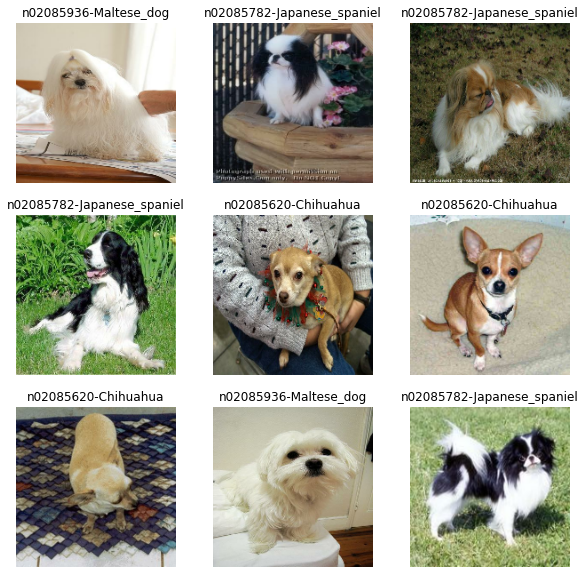

In [105]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [107]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [108]:
normalization_layer = layers.Rescaling(1./255)

In [109]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [110]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [111]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [112]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [117]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
19/19 [==============================] - 8s 394ms/step - loss: 1.2258 - accuracy: 0.4535 - val_loss: 1.1186 - val_accuracy: 0.5578
Epoch 2/10
19/19 [==============================] - 8s 401ms/step - loss: 1.0337 - accuracy: 0.5838 - val_loss: 1.2301 - val_accuracy: 0.4830
Epoch 3/10
19/19 [==============================] - 7s 392ms/step - loss: 0.9380 - accuracy: 0.6193 - val_loss: 1.1424 - val_accuracy: 0.5714
Epoch 4/10
19/19 [==============================] - 7s 392ms/step - loss: 0.8094 - accuracy: 0.6548 - val_loss: 1.0904 - val_accuracy: 0.6395
Epoch 5/10
19/19 [==============================] - 7s 392ms/step - loss: 0.6218 - accuracy: 0.7614 - val_loss: 1.1770 - val_accuracy: 0.5646
Epoch 6/10
19/19 [==============================] - 7s 392ms/step - loss: 0.4694 - accuracy: 0.8325 - val_loss: 1.2407 - val_accuracy: 0.5918
Epoch 7/10
19/19 [==============================] - 7s 392ms/step - loss: 0.3113 - accuracy: 0.9086 - val_loss: 1.3538 - val_accuracy: 0.6190
Epoch 

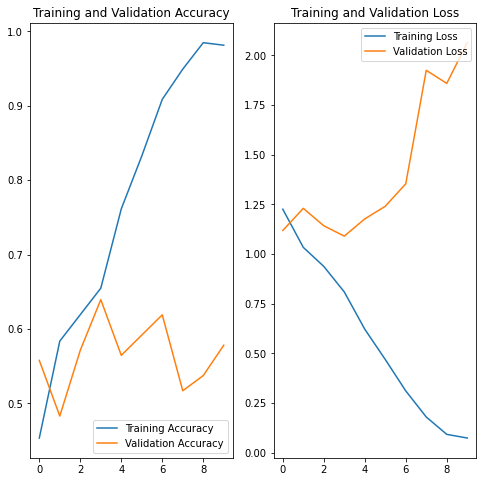

In [118]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [119]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

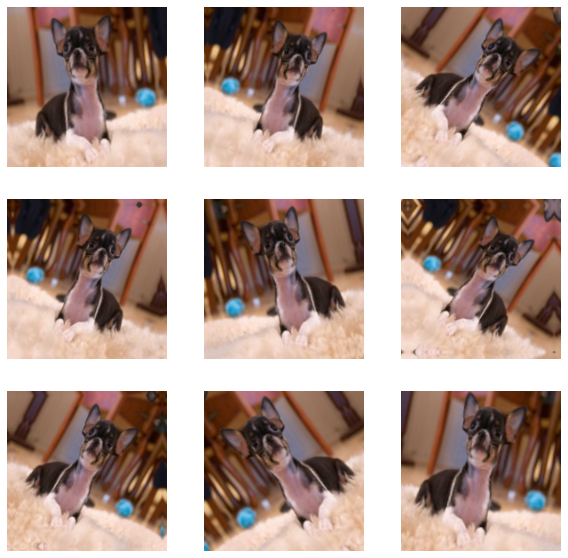

In [120]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [121]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [122]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [123]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [124]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
19/19 [==============================] - 11s 499ms/step - loss: 1.9061 - accuracy: 0.2707 - val_loss: 1.4408 - val_accuracy: 0.3469
Epoch 2/10
19/19 [==============================] - 10s 504ms/step - loss: 1.2961 - accuracy: 0.4247 - val_loss: 1.2432 - val_accuracy: 0.4694
Epoch 3/10
19/19 [==============================] - 9s 480ms/step - loss: 1.1790 - accuracy: 0.4975 - val_loss: 1.2372 - val_accuracy: 0.5102
Epoch 4/10
19/19 [==============================] - 9s 466ms/step - loss: 1.1422 - accuracy: 0.5178 - val_loss: 1.1612 - val_accuracy: 0.5306
Epoch 5/10
19/19 [==============================] - 9s 466ms/step - loss: 1.0704 - accuracy: 0.5245 - val_loss: 1.1277 - val_accuracy: 0.5374
Epoch 6/10
19/19 [==============================] - 9s 467ms/step - loss: 1.0539 - accuracy: 0.5499 - val_loss: 1.1042 - val_accuracy: 0.5510
Epoch 7/10
19/19 [==============================] - 9s 464ms/step - loss: 1.0268 - accuracy: 0.5804 - val_loss: 1.0713 - val_accuracy: 0.5510
Epoc

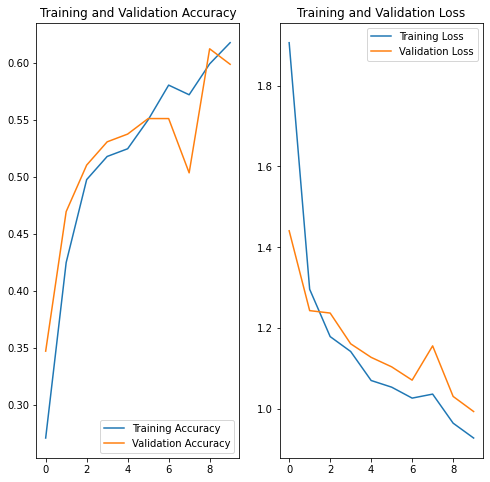

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()